### BASE DE DATOS DE LA EVOLUCIÓN DEL CLIMA

---

##### Trabajo practico II - Analisis predictivo avanzado - ITBA
##### *Entrega final*


### PASO 1: Importar librerias

In [1]:
import pandas as pd
import requests
from datetime import datetime
import warnings
import datetime
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, auc, RocCurveDisplay
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.pipeline import FeatureUnion, Pipeline
import xgboost as xgb
import matplotlib.colors as mcolors
from pandas.plotting import scatter_matrix
import geopy
import geopy.distance as distance
import shapely.wkt
from shapely.geometry import LineString, Point
import geopandas as gpd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.io as pio

### PASO 2: abrir el dataset

In [2]:
# CARGAMOS EL DATASET #
df = pd.read_csv('ClimateChange.csv')

In [3]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
239172,5/1/2013,18.979,0.807,Xian,China,34.56N,108.97E
239173,6/1/2013,23.522,0.647,Xian,China,34.56N,108.97E
239174,7/1/2013,25.251,1.042,Xian,China,34.56N,108.97E
239175,8/1/2013,24.528,0.840,Xian,China,34.56N,108.97E


In [4]:
# ESTANDARIZAMOS LAS FECHAS #
import pandas as pd
from datetime import datetime

def separar_fecha(df, columna):
    # Itera sobre las filas del DataFrame
    for index, fila in df.iterrows():
        fecha = fila[columna]

        if "-" in fecha:
            # Convierte la cadena de fecha al objeto datetime
            fecha_obj = datetime.strptime(fecha, '%Y-%d-%m')
        else:
            # Convierte la cadena de fecha al objeto datetime para el caso sin "-"
            fecha_obj = datetime.strptime(fecha, '%d/%m/%Y')

        # Agrega columnas al DataFrame para día, mes, año y fecha formateada
        df.at[index, "mes"] = int(fecha_obj.day)
        df.at[index, "dia"] = int(fecha_obj.month)
        df.at[index, "anio"] = int(fecha_obj.year)
        df.at[index, "dt"] = fecha_obj.strftime('%d/%m/%Y')

    return df


# CONVERTIR LAS COORDENADAS #
def convertir_coordenadas(coordenada):
    deg = float(coordenada[:-1])
    direction = coordenada[-1]
    decimal_coord = deg if direction.upper() in ['N', 'E'] else -deg if direction.upper() in ['S', 'W'] else None
    return decimal_coord

In [5]:
df = separar_fecha(df, "dt")
df['Latitude'] = df['Latitude'].apply(convertir_coordenadas)
df['Longitude'] = df['Longitude'].apply(convertir_coordenadas)

In [6]:
df['dt'] = pd.to_datetime(df['dt'])

df = df[df['dt'].dt.year >= 2000]

In [7]:
# VALORES DE LOS MESES #
valores_mes_unicos = df['mes'].unique()
print(valores_mes_unicos)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


### PASO 3: eda - analisis general de la base

##### Primer aproach

In [8]:
num_filas, num_columnas = df.shape
print("Cantidad de filas:", num_filas)
print("Cantidad de columnas:", num_columnas)

Cantidad de filas: 16500
Cantidad de columnas: 10


In [9]:
columnas_categoricas= df.select_dtypes(include=['object'])

columnas_numericas = df.select_dtypes(exclude=['object'])

print("Tipos de columnas:")
print("Categoricas:",columnas_categoricas.columns)
print("Numericas",columnas_numericas.columns)

Tipos de columnas:
Categoricas: Index(['City', 'Country'], dtype='object')
Numericas Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Latitude',
       'Longitude', 'mes', 'dia', 'anio'],
      dtype='object')


##### Columnas categoricas

In [10]:
# VALORES UNICOS EN COLUMNAS CATEGORICAS #
cantidad_valores_unicos = columnas_categoricas.nunique()
cantidad_valores_unicos

City       100
Country     49
dtype: int64

In [11]:
# VALORES NULOS #
cantidad_nulos_categoricas = columnas_categoricas.isnull().sum()
cantidad_nulos_categoricas

City       0
Country    0
dtype: int64

##### Columnas numericas

In [12]:
# VALORES NULOS #
cantidad_nulos_numericas= columnas_numericas.isnull().sum()
cantidad_nulos_numericas

dt                                0
AverageTemperature               93
AverageTemperatureUncertainty    93
Latitude                          0
Longitude                         0
mes                               0
dia                               0
anio                              0
dtype: int64

In [13]:
# OUTLIERS #
if 'dt' in columnas_numericas.columns:
    columnas_numericas = columnas_numericas.drop(columns=['dt'])

stats = columnas_numericas.describe()
Q1 = stats.loc['25%']
Q3 = stats.loc['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Outliers de cada variable:")
outliers = ((columnas_numericas < lower_bound) | (columnas_numericas > upper_bound))
outlier_counts = outliers.sum()
outlier_counts

Outliers de cada variable:


AverageTemperature               421
AverageTemperatureUncertainty    922
Latitude                         165
Longitude                          0
mes                                0
dia                                0
anio                               0
dtype: int64

In [14]:
# ESTADISTICOS DESCRIPTIVOS #
estadisticas_descriptivas = columnas_numericas.describe()
estadisticas_descriptivas

,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,mes,dia,anio
count,16407.000000,16407.000000,16500.000000,16500.000000,16500.000000,16500.0,16500.000000
mean,19.732877,0.385150,20.060700,45.461900,6.418182,1.0,2006.381818
std,9.579635,0.233579,22.369682,65.804407,3.427397,0.0,3.970423
min,-23.495000,0.056000,-37.780000,-118.700000,1.000000,1.0,2000.000000
25%,14.870000,0.243000,6.830000,7.177500,3.000000,1.0,2003.000000
50%,22.119000,0.330000,24.920000,45.955000,6.000000,1.0,2006.000000
75%,27.001500,0.454000,36.170000,104.382500,9.000000,1.0,2010.000000
max,38.283000,3.963000,60.270000,151.780000,12.000000,1.0,2013.000000


##### Imputacion de missings

In [15]:
df['dt'] = pd.to_datetime(df['dt'])
city_monthly_mean = df.groupby(['City', df['dt'].dt.month])['AverageTemperature'].mean()
city_monthly_mean1 = df.groupby(['City', df['dt'].dt.month])['AverageTemperatureUncertainty'].mean()

for index, row in df.iterrows():
    city = row['City']
    month = row['dt'].month
    if pd.isnull(row['AverageTemperature']):
        mean_value = city_monthly_mean.get((city, month))
        df.at[index, 'AverageTemperature'] = mean_value
    if pd.isnull(row['AverageTemperatureUncertainty']):
        mean_value1 = city_monthly_mean1.get((city, month))
        df.at[index, 'AverageTemperatureUncertainty'] = mean_value1

<ipython-input-15-d6e06f970892>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['dt'])


In [16]:
null_counts = df.isnull().sum()
print(null_counts)

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
mes                              0
dia                              0
anio                             0
dtype: int64


### PASO 4: eda - análisis gráfico

#### Variables categoricas

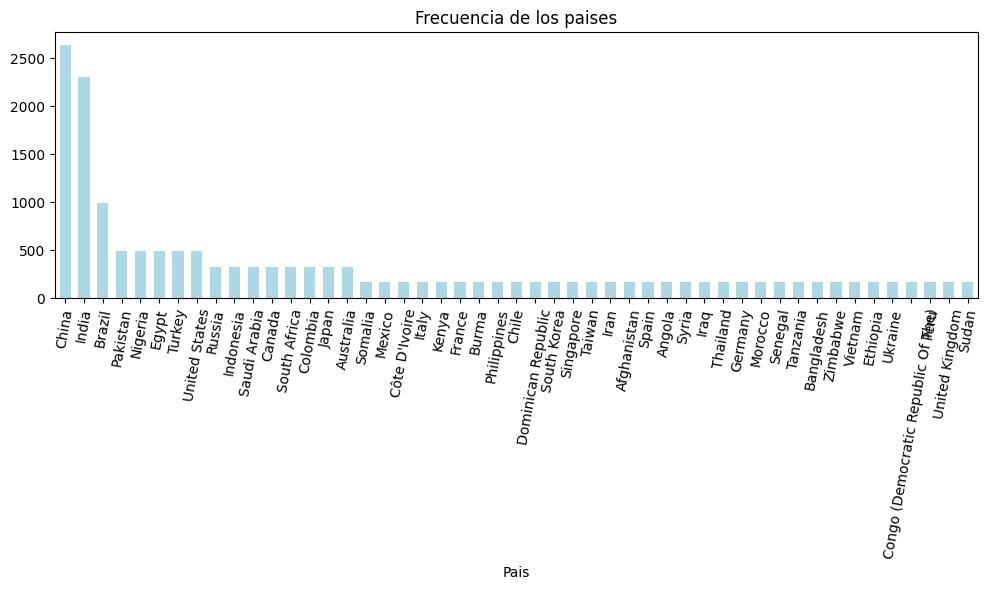

In [17]:
# GRAFICO DE FRECUENCIA DE LOS PAISES #
frecuencia_paises = df['Country'].value_counts()
plt.figure(figsize=(10, 6))
frecuencia_paises.plot(kind='bar', color='#ADD8E6', width=0.6)
plt.title('Frecuencia de los paises')
plt.xlabel('Pais')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

#### Variables numericas

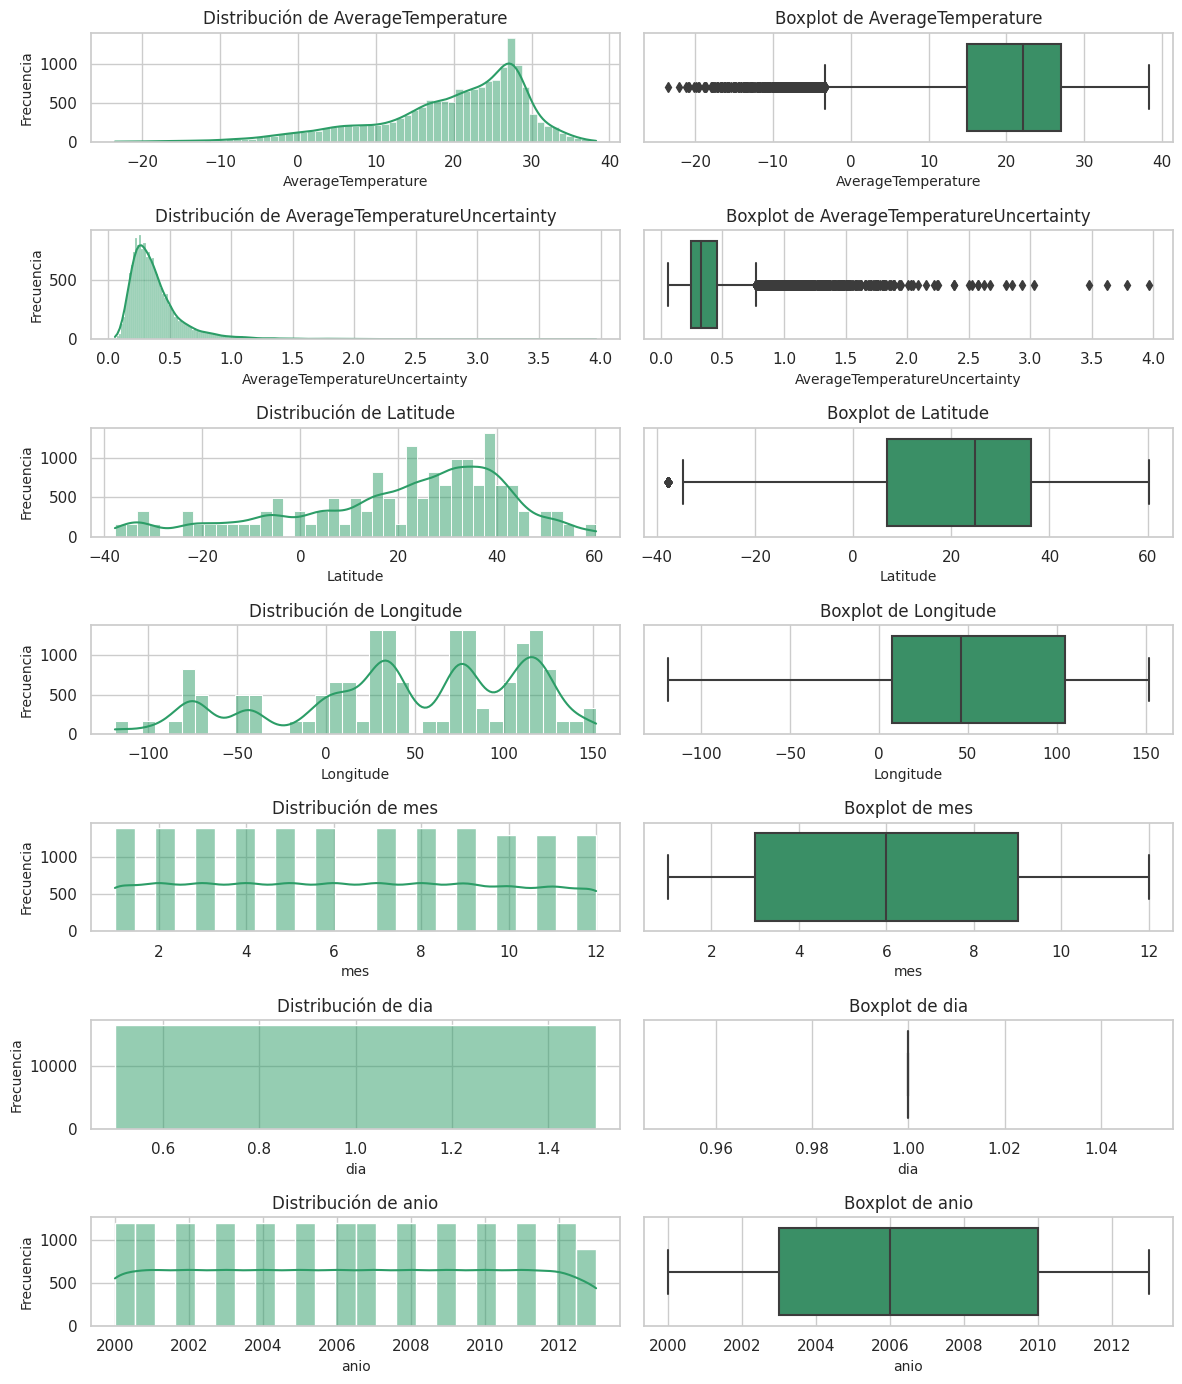

In [18]:
sns.set(style="whitegrid", palette="deep")

# Crear subplots para los gráficos
fig, axes = plt.subplots(nrows=len(columnas_numericas.columns), ncols=2, figsize=(12, 2 * len(columnas_numericas.columns)))

# Iterar a través de las columnas numéricas
for i, columna in enumerate(columnas_numericas.columns):
    # Gráfico de distribución
    sns.histplot(data=df, x=columna, color='#2C9D67', kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribución de {columna}', fontsize=12)
    axes[i, 0].set_xlabel(columna, fontsize=10)
    axes[i, 0].set_ylabel('Frecuencia', fontsize=10)

    # Boxplot
    sns.boxplot(data=df, x=columna, color='#2C9D67', ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {columna}', fontsize=12)
    axes[i, 1].set_xlabel(columna, fontsize=10)

# Ajustar la disposición de los gráficos
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:97: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:102: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:92: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


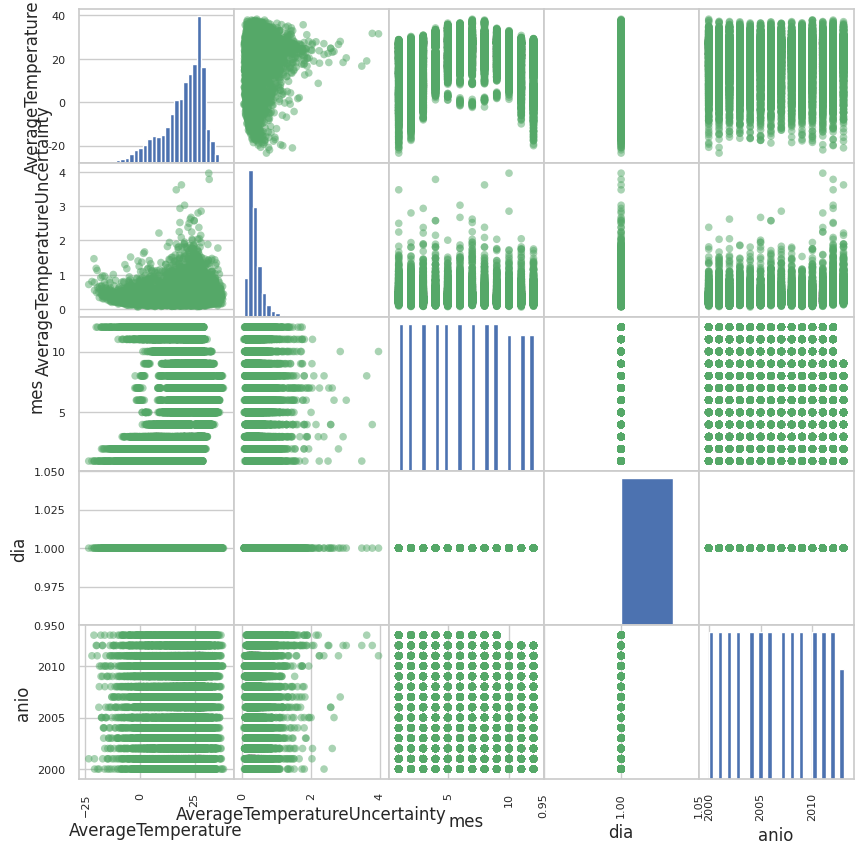

In [19]:
bm = df.columns.isin(['AverageTemperature', 'AverageTemperatureUncertainty','dia', 'mes', 'anio'])
sc = df.columns[bm]
data = df[sc]

# Aumenta la separación entre los ejes X e Y y ajusta el tamaño de los puntos
scatter_matrix(data, alpha=0.5, figsize=(10, 10),
               marker='o', hist_kwds={'bins': 30}, s=30,
               range_padding=0.15, cmap=plt.cm.brg, diagonal='hist', color="g")

plt.show()

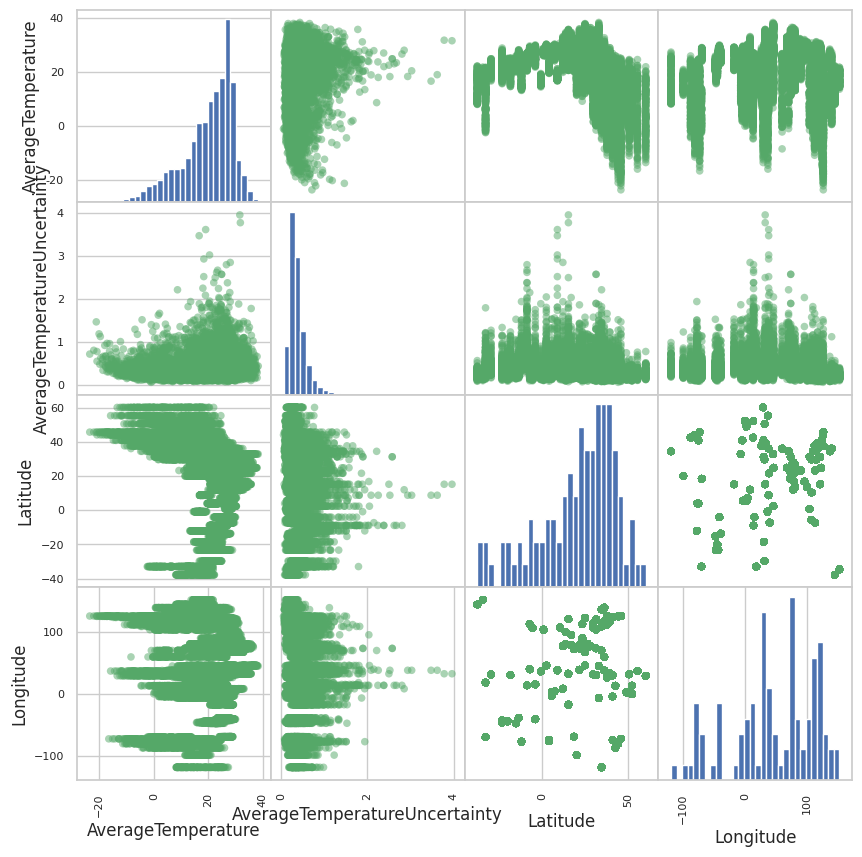

In [20]:
bm = df.columns.isin(['AverageTemperature', 'AverageTemperatureUncertainty', 'Latitude',
       'Longitude'])
sc = df.columns[bm]
data = df[sc]

# Aumenta la separación entre los ejes X e Y y ajusta el tamaño de los puntos
scatter_matrix(data, alpha=0.5, figsize=(10, 10),
               marker='o', hist_kwds={'bins': 30}, s=30,
               range_padding=0.15, cmap=plt.cm.brg, diagonal='hist', color="g")

plt.show()

### PASO 5: GIS

#### Graficos generales

In [21]:
# LISTA DE PAISES DE NUESTRO DF #
paises_unicos = df['Country'].unique().tolist()

# DATASET CON TODOS LOS PAISES (NATIVO) #
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# DF CON LAS CIUDADES #
df_ciudad = df[['Country', 'City', 'Latitude', 'Longitude']]
geo_ciudad=gpd.GeoDataFrame(df_ciudad,geometry=gpd.points_from_xy(df_ciudad.Longitude, df_ciudad.Latitude))

# DATOS DE LOS PAISES QUE TENEMOS #
geo_nuestro = world[world['name'].isin(paises_unicos)]

<ipython-input-21-c6442e62eae0>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


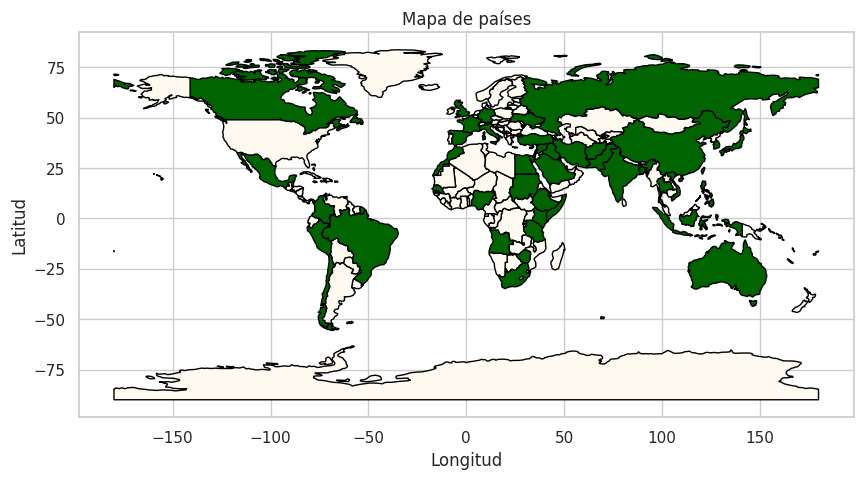

In [22]:
# MAPA MUNDIAL #
# EN VERDE LOS PAISES QUE ESTAN EN NUESTRO DATASET
# EN BLANCO LOS PAISES QUE NO ESTAN
world['in_geo_nuestro'] = world['name'].isin(paises_unicos)
fig, ax = plt.subplots(figsize=(10, 8))
world[world['in_geo_nuestro'] == False].plot(ax=ax, color='#FFFAF0', edgecolor='black')
world[world['in_geo_nuestro'] == True].plot(ax=ax, color='#006400', edgecolor='black')
plt.title('Mapa de países')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
world.drop('in_geo_nuestro', axis=1, inplace=True)
plt.show()

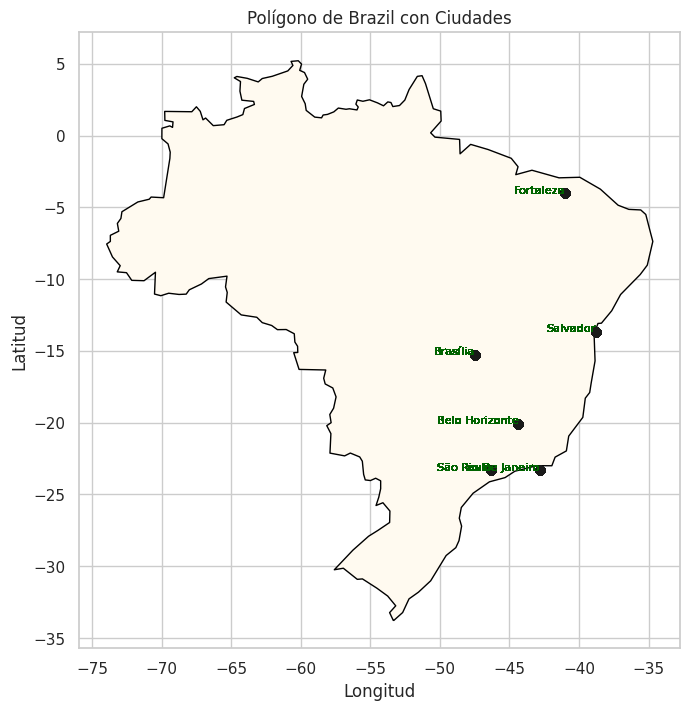

In [23]:
# MAPA DE LOS PAISES
def plot_country_cities(country_name, df, world_data):
    ciudades_pais = df[df['Country'] == country_name]
    geo_pais = world_data[world_data['name'] == country_name]
    fig, ax = plt.subplots(figsize=(10, 8))
    geo_pais.plot(ax=ax, color='#FFFAF0', edgecolor='black')
    for x, y, label in zip(ciudades_pais['Longitude'], ciudades_pais['Latitude'], ciudades_pais['City']):
        ax.text(x, y, label, fontsize=8, ha='right', color="#006400")
        ax.plot(x, y, 'ko')
    plt.title(f'Polígono de {country_name} con Ciudades')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.show()

# Seleccionar el pais que se desea plotear
plot_country_cities('Brazil', geo_ciudad, world)

#### Grafico interactivo

##### Grafico fijo (los valores se cambian a mano)

In [24]:
# 1. Calcula la temperatura promedio por país, año y mes
df['temp_promedio_pais'] = df.groupby(['Country', 'anio', 'mes'])['AverageTemperature'].transform('mean')

# 2. Achicar un poco el df
selected_columns = ['Country', 'anio', 'mes', 'temp_promedio_pais']
df_graficos = df[selected_columns]

# 3. Traer el json del world map
import json
world_json = json.load(open("countries.geo.json","r"))

# 4. Se agrega un id al df para identificar a los paises
world_id_map = {}
if "features" in world_json:
    for feature in world_json["features"]:
        properties = feature.get("properties", {})
        feature_id = properties.get("name")

        if feature_id:
            feature["id"] = feature_id
            world_id_map[feature_id] = feature["id"]
        else:
            print("Name not found in properties:", feature)
else:
    print("Key 'features' not found in world_json")
df_graficos["id"] = df_graficos["Country"].apply(lambda x: world_id_map.get(x, "Unknown"))

# 5. Graficar el Chloropleth map
anio = 2002
mes= 6
df_graficos_especifico = df_graficos[(df_graficos["anio"] == anio) & (df_graficos["mes"] == mes)]

pio.renderers.default = None
fig = px.choropleth(df_graficos_especifico, locations = "id", geojson = world_json, color = 'temp_promedio_pais')

<ipython-input-24-256d844d8be2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_promedio_pais'] = df.groupby(['Country', 'anio', 'mes'])['AverageTemperature'].transform('mean')
<ipython-input-24-256d844d8be2>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graficos["id"] = df_graficos["Country"].apply(lambda x: world_id_map.get(x, "Unknown"))


In [25]:
fig.show(renderer="colab")

##### Grafico interactivo (los valores se pueden cambiar desde el grafic)

In [ ]:
pip install dash

In [28]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px

# Supongamos que ya tienes el DataFrame df_graficos creado

# 1. Crear la aplicación de Dash
app = dash.Dash(__name__)

# 2. Lista de años y meses
lista_años = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
lista_meses = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# 3. Diseño de la interfaz de la aplicación
app.layout = html.Div([
    html.H1("Choropleth Map con Dash", style={'textAlign': 'center'}),

    # Se muestra el subtítulo con el año y mes seleccionado
    html.H3(id='subtitulo', style={'textAlign': 'center'}),

    # Para elegir el año
    dcc.Dropdown(
        id='dropdown-año',
        options=[{'label': str(año), 'value': año} for año in lista_años],
        value=lista_años[0],
        style={'width': '50%'}),

    # Para seleccionar el mes
    dcc.Slider(
        id='slider-mes',
        min=min(lista_meses),
        max=max(lista_meses),
        step=1,
        marks={mes: str(mes) for mes in lista_meses},
        value=lista_meses[0],),

    # Gráfico Choropleth
    dcc.Graph(id='choropleth-map')])

# 4. Actualizar el gráfico y el subtitulo según las selecciones del usuario
@app.callback(
    [Output('choropleth-map', 'figure'),
     Output('subtitulo', 'children')],
    [Input('dropdown-año', 'value'),
     Input('slider-mes', 'value')])

def update_choropleth_map(selected_año, selected_mes):
    df_graficos_especifico = df_graficos[(df_graficos["anio"] == selected_año) & (df_graficos["mes"] == selected_mes)]
    fig = px.choropleth(df_graficos_especifico, locations="id", geojson=world_json, color='temp_promedio_pais')
    subtitulo_texto = f'Año seleccionado: {selected_año}, Mes seleccionado: {selected_mes}'

    return fig, subtitulo_texto

# 5. Se ejecuta la aplicación
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

##### Grafico para ver como fue la evolucion del clima

In [ ]:
### PASO 1: se vuelve a cargar el dataset para que esten presentes todos los años ###

# ABRIR LA BDD #
df_entero = pd.read_csv('ClimateChange.csv')

# ESTANDARIZAMOS LAS FECHAS #
from datetime import datetime

def separar_fecha(df, columna):
    for index, fila in df.iterrows():
        fecha = fila[columna]
        if "-" in fecha:
            fecha_obj = datetime.strptime(fecha, '%Y-%d-%m')
        else:
            fecha_obj = datetime.strptime(fecha, '%d/%m/%Y')

        df.at[index, "mes"] = int(fecha_obj.day)
        df.at[index, "dia"] = int(fecha_obj.month)
        df.at[index, "anio"] = int(fecha_obj.year)
        df.at[index, "dt"] = fecha_obj.strftime('%d/%m/%Y')
    return df

# APLICAR LA ESTANDARIZACION AL DF ENTERO #
df_entero = separar_fecha(df_entero, "dt")

In [29]:
# LISTA DE AÑOS QUE VAMOS A VISUALIZAR #
años_gráfico =[1750,1800,1850,1900,1950,2000]

# 1. Calcula la temperatura promedio por país, año y mes
df['temp_promedio_pais'] = df.groupby(['Country', 'anio', 'mes'])['AverageTemperature'].transform('mean')

# 2. Achicar un poco el df
selected_columns = ['Country', 'anio', 'mes', 'temp_promedio_pais']
df_graficos = df[selected_columns]

# 3. Traer el json del world map
import json
world_json = json.load(open("countries.geo.json","r"))

# 4. Se agrega un id al df para identificar a los paises
world_id_map = {}
if "features" in world_json:
    for feature in world_json["features"]:
        properties = feature.get("properties", {})
        feature_id = properties.get("name")

        if feature_id:
            feature["id"] = feature_id
            world_id_map[feature_id] = feature["id"]
        else:
            print("Name not found in properties:", feature)
else:
    print("Key 'features' not found in world_json")
df_graficos["id"] = df_graficos["Country"].apply(lambda x: world_id_map.get(x, "Unknown"))

<ipython-input-29-a633f81f006c>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-a633f81f006c>:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
# 5. Graficar el Chloropleth map
anio = 2002
mes= 1
df_graficos_especifico = df_graficos[(df_graficos["anio"] == anio) & (df_graficos["mes"] == mes)]

pio.renderers.default = None
fig = px.choropleth(df_graficos_especifico, locations = "id", geojson = world_json, color = 'temp_promedio_pais')

pio.renderers.default = None
fig = px.choropleth(df_graficos_especifico, locations="id", geojson=world_json, color='temp_promedio_pais')

# Añadir la anotación del año en la parte inferior derecha
fig.add_annotation(
    text=str(anio),
    x=1,  # Coordenada x en el rango [0, 1]
    y=-0.1,  # Coordenada y en el rango [0, 1]
    showarrow=False,
    font=dict(size=14, color="black"),
    bgcolor="rgba(255, 255, 255, 0.6)",
    bordercolor="rgba(0, 0, 0, 0.6)",
    borderwidth=1,
)

# Mostrar el gráfico
fig.show(renderer="colab")

### PASO 6: Experimentacion de series de tiempo (experimentamos con china)

In [32]:
dfnuevo = df[df['Country'] == 'China']
dfnuevo['anio_mes'] = dfnuevo['dt'].dt.strftime('%Y-%m')
dfmundo = dfnuevo.groupby('anio_mes')['AverageTemperature'].mean().reset_index()
dfmundo['anio_mes'] = pd.to_datetime(dfmundo['anio_mes'])
dfmundo = dfmundo.set_index('anio_mes')
y = dfmundo['AverageTemperature'].resample('MS').mean()

<ipython-input-32-605363b38a5d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
y

anio_mes
2000-01-01    -3.958375
2000-02-01    -0.481938
2000-03-01     7.863375
2000-04-01    13.763312
2000-05-01    20.225250
                ...    
2013-05-01    20.262688
2013-06-01    23.650125
2013-07-01    26.468000
2013-08-01    26.284500
2013-09-01    20.483303
Freq: MS, Name: AverageTemperature, Length: 165, dtype: float64

#### Graficos

<Figure size 2000x2000 with 0 Axes>

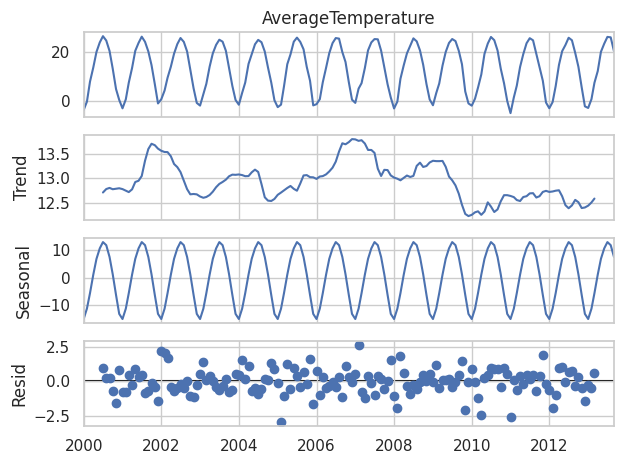

In [34]:
plt.figure(figsize=(20,20))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

<Figure size 1000x300 with 0 Axes>

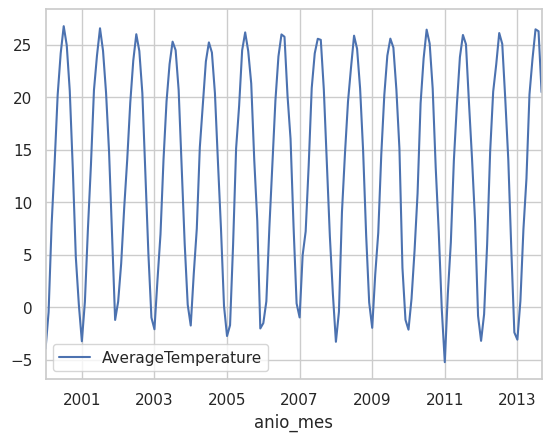

In [35]:
plt.figure(figsize=(10,3)); dfmundo.plot(); plt.show()

#### Se realiza la division en train y test

Para el test, se tomaron los ultimos 3 años. Luego, se verifico ue los últimos meses de train no sean consecutivos a los meses de test.

In [36]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dfmundo, test_size=36, random_state=42, shuffle=False)

In [37]:
df_test.head(2)

,AverageTemperature
anio_mes,
2010-10-01,13.286312
2010-11-01,7.181437


In [38]:
df_train.tail(2)

,AverageTemperature
anio_mes,
2010-08-01,25.109687
2010-09-01,20.814500


#### Random walk

Se agregó una columna que almacene el valor de la tempreatura del dia anterior, para esto, el primer mes se almacena con su misma temperatura

In [39]:
df_train["RandomWalk"] = df_train.AverageTemperature.shift()

# La primera observación nos va a quedar en nan, la reemplazamos por el valor siguente:
df_train["RandomWalk"].fillna(method='bfill', inplace=True)
df_train.head(3)

,AverageTemperature,RandomWalk
anio_mes,,
2000-01-01,-3.958375,-3.958375
2000-02-01,-0.481938,-3.958375
2000-03-01,7.863375,-0.481938


Se grafica la temperatura diaria promedio y el random walk (la temperatura promedio del dia anterior)

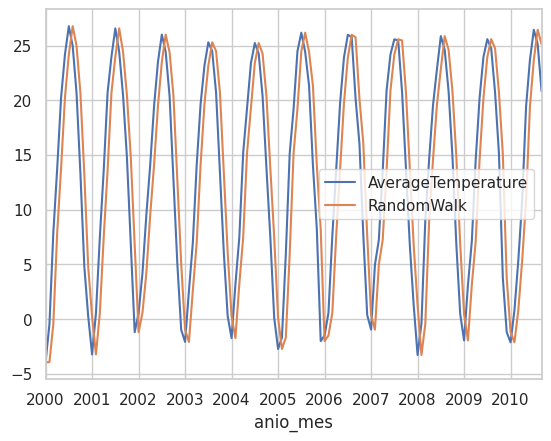

In [40]:
df_train.plot(kind="line", y = ["AverageTemperature", "RandomWalk"]);

En el Random Walk la predicción se basa en el valor anterior, por eso para la predicción de los 3 años de test se tomará el ultimo valor de train

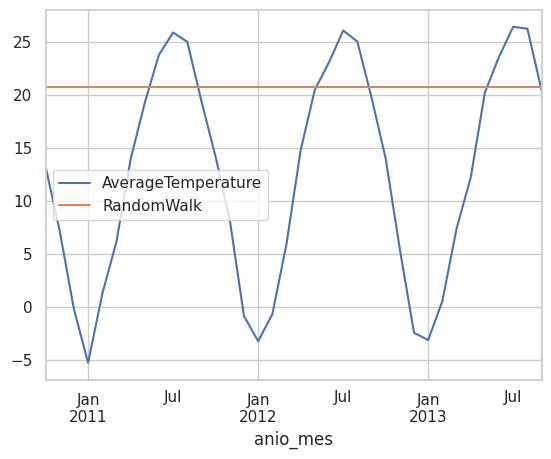

In [41]:
df_test["RandomWalk"] = pd.Series(df_train["AverageTemperature"][-1], index=df_test.index)
df_test.plot(kind="line", y = ["AverageTemperature", "RandomWalk"]);

In [42]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [43]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Random Walk"
df_Results.loc[0, "RMSE"] = RMSE(df_test.RandomWalk, df_test.AverageTemperature)
df_Results

,Model,RMSE
0,Random Walk,13.130778


#### Modelo de tendencia cuadratica

Para este método es necesario agregar el índice según el valor aniomes y ese índice al cuadrado

In [44]:
dfmundo["timeIndex"] = pd.Series(np.arange(len(dfmundo['AverageTemperature'])), index=dfmundo.index)
dfmundo.timeIndex.head(3)

anio_mes
2000-01-01    0
2000-02-01    1
2000-03-01    2
Name: timeIndex, dtype: int64

In [45]:
dfmundo["timeIndex_sq"] = dfmundo["timeIndex"]**2
dfmundo.timeIndex_sq.head(3)

anio_mes
2000-01-01    0
2000-02-01    1
2000-03-01    4
Name: timeIndex_sq, dtype: int64

In [46]:
df_train, df_test = train_test_split(dfmundo, test_size=36, random_state=42, shuffle=False)

##### Realizamos un modelo cuadratico

In [62]:
import statsmodels.formula.api as smf
model_quadratic = smf.ols('log_temperature ~ timeIndex + timeIndex_sq', data = df_train).fit()

In [63]:
df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["timeIndex","timeIndex_sq"]])
df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["timeIndex","timeIndex_sq"]])

#### Transformación logarítmica + estacionalidad mensual

In [48]:
# Volvemos a hacer la division de train y test ya que agregamos nuevas columnas de índice #
df_train, df_test = train_test_split(dfmundo, test_size=36, random_state=42, shuffle=False)

In [49]:
# Aplicamos logaritmo a los datos para reducir la variabilidad #
df_train['log_temperature'] = np.log(df_train['AverageTemperature'])
df_test['log_temperature'] = np.log(df_test['AverageTemperature'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



In [50]:
# Creamos una dummy por cada mes, para poder captar la estacionalidad #
df_train['month'] = [d.strftime('%b') for d in df_train.index]
df_test['month']  = [d.strftime('%b') for d in df_test.index]
dummies_mes_train = pd.get_dummies(df_train['month'])
dummies_mes_test = pd.get_dummies(df_test['month'])
df_train = df_train.join(dummies_mes_train)
df_test = df_test.join(dummies_mes_test)

#### Modelo de regresión lineal con logaritmo y el factor estacional

In [51]:
model_log_est = smf.ols('log_temperature ~ timeIndex + Apr + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()

In [52]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex","Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])

df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex","Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])

In [53]:
# SE DEVUELVE LOS DATOS PREDICHOS DE TEMPERATURA A SU ESTADO ORIGINAL,
# APLICANDO LA FUNCION EXPONENCIAL #
df_train['back_LogEstTrend'] = np.exp(df_train['model_log_est'])
df_test['back_LogEstTrend'] = np.exp(df_test['model_log_est'])

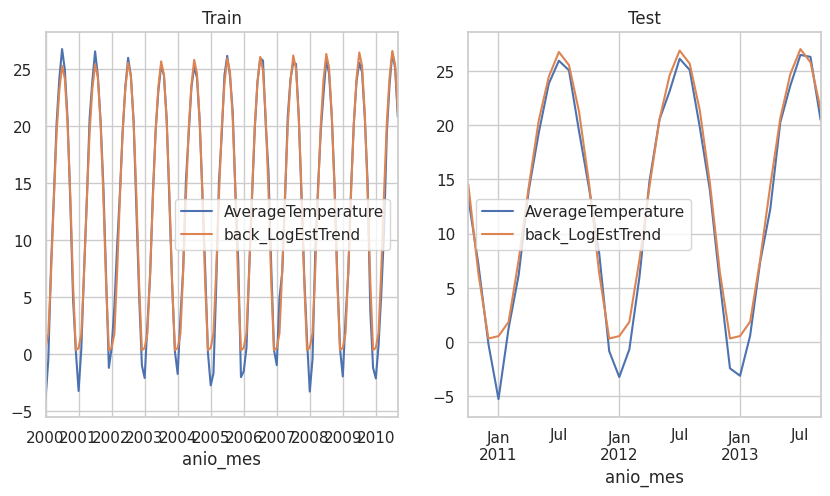

In [54]:
# Se grafican las predicciones vs los valores originales
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["AverageTemperature","back_LogEstTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["AverageTemperature","back_LogEstTrend"],ax=axes[1],title='Test');
plt.show()

In [55]:
# Calculamos el RMSE y lo comparamos con el del Random Walk
model_RMSE = RMSE(df_test.back_LogEstTrend, df_test.AverageTemperature)
df_Results.loc[5, "Model"] = "back_LogEstTrend"
df_Results.loc[5, "RMSE"] = model_RMSE
df_Results

,Model,RMSE
0,Random Walk,13.130778
5,back_LogEstTrend,1.747488


#### Modelo ARIMA

In [57]:
# Creamos un nuevo dataframe que solo tenga la temperatura promedio mensual #
dfmundoSERIES= dfmundo.iloc[:, 0]
dfmundoSERIES

anio_mes
2000-01-01    -3.958375
2000-02-01    -0.481938
2000-03-01     7.863375
2000-04-01    13.763312
2000-05-01    20.225250
                ...    
2013-05-01    20.262688
2013-06-01    23.650125
2013-07-01    26.468000
2013-08-01    26.284500
2013-09-01    20.483303
Name: AverageTemperature, Length: 165, dtype: float64

##### Grafico de la serie

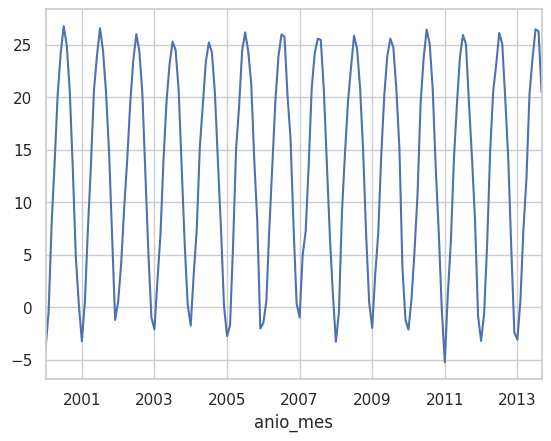

In [58]:
from matplotlib import pyplot
dfmundoSERIES.plot()
pyplot.show()

##### Grafico de los lags ACF

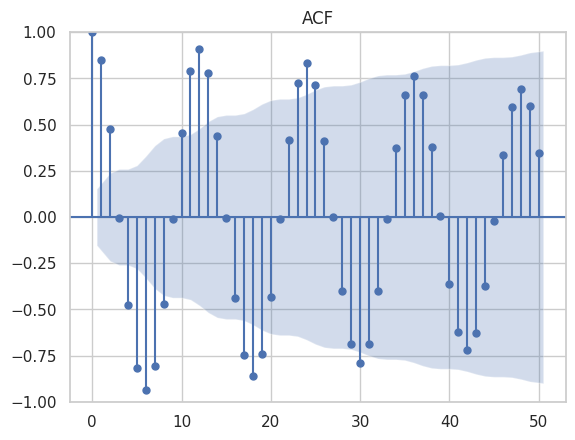

In [59]:
# Graficamos los lags ACF, es decir, la correlación de la variable contra sí misma en otro momento del tiempo #
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt

smt.graphics.plot_acf(dfmundoSERIES, lags=50,title='ACF')
plt.show()

##### Grafico de los lags PACF

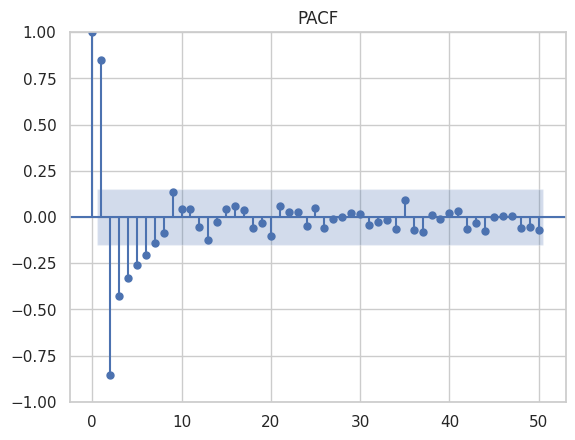

In [60]:
# Objetivo: Resumen de la relación entre una observación en una serie temporal con las observaciones previas,
# eliminando la correlación con las observaciones intermedias
smt.graphics.plot_pacf(dfmundoSERIES, lags=50,title='PACF')
plt.show()

##### Test de hipotesis

Además de observar los lags para detectar tendencia, realizamos un test de hipótesis. Es un test donde la hipótesis nula $H_0$ indica que la serie no es estacionaria.
En otras palabras
- si p > 0.05 (nivel de significación mayor al 5%),  **$H_0$ no se rechaza**, y la serie *no es estacionaria*.
- Caso contrario, si p < 0.05, **la hipótesis nula se rechaza** y se considera *estacionaria*.


In [61]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(dfmundoSERIES);
print('ADF Statistic: %f' % result[0]); print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -2.552465
p-value: 0.103225
Valor crítico 1%: -3.47
Valor crítico 5%: -2.88
Valor crítico 10%: -2.58


### PASO 7: chequear estacionaridad

En el caso de China, la serie no es estacionaria por lo que hay que modificarla.

Como la serie no es estacionaria, d=1. ARIMA(p,d,q)

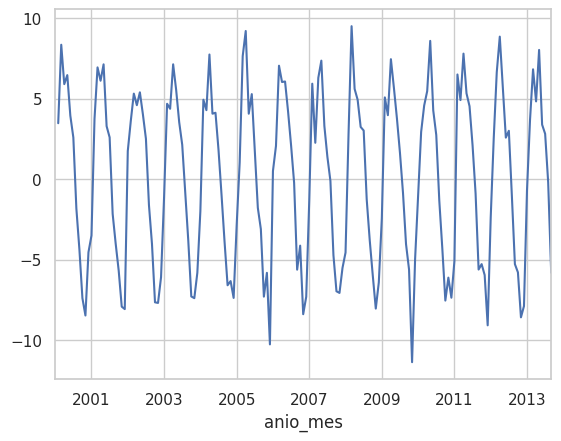

In [64]:
dfmundoSERIESdif=dfmundoSERIES.diff()
dfmundoSERIESdif.plot();

##### Se cuentan la cantidad de lags significativos en ACF(q) Y PACF (p)

In [65]:
model_ARIMA = ARIMA(dfmundoSERIES, order=(6,1,10))
results_ARIMA = model_ARIMA.fit()
results_ARIMA.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     AverageTemperature   No. Observations:                  165
Model:                ARIMA(6, 1, 10)   Log Likelihood                -278.238
Date:                Fri, 01 Dec 2023   AIC                            590.475
Time:                        21:17:48   BIC                            643.173
Sample:                    01-01-2000   HQIC                           611.868
                         - 09-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8847      0.248      3.564      0.000       0.398       1.371
ar.L2          0.1472      0.372      0.396      0.692      -0.582       0.876
ar.L3         -1.0102      0.324     -3.123      0.002      -1.644      -0.376
ar.L4          0.2053      0.285      0.719      0.472      -0.354       0.765
ar.L5          0.5260      0.248      2.121      0.034       0.040       1.012
ar.L6         -0.7174      0.171     -4.205      0.000      -1.052      -0.383
ma.L1         -1.4508      0.406     -3.569      0.000      -2.247      -0.654
ma.L2         -0.0665      0.547     -0.122      0.903      -1.138       1.005
ma.L3          1.2604      0.494      2.552      0.011       0.292       2.229
ma.L4         -0.5013      0.438     -1.144      0.253      -1.360       0.357
ma.L5         -0.8866      0.439     -2.020      0.043      -1.747      -0.026
ma.L6          0.9969      0.344      2.898      0.004       0.323       1.671
ma.L7         -0.0386      0.217     -0.177      0.859      -0.465       0.388
ma.L8         -0.5990      0.159     -3.765      0.000      -0.911      -0.287
ma.L9          0.0864      0.269      0.321      0.748      -0.441       0.614
ma.L10         0.2993      0.221      1.356      0.175      -0.133       0.732
sigma2         1.5046      0.564      2.669      0.008       0.400       2.609
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.63   Prob(JB):                         0.51
Heteroskedasticity (H):               1.02   Skew:                            -0.12
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Se realiza la predicccion

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=-1.241141, expected=-1.969125


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.318558, expected=3.109313


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=7.620984, expected=7.083687


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=12.846893, expected=14.533188


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=19.367989, expected=20.193562


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=25.106770, expected=23.953500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=25.669793, expected=25.580562


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=24.019552, expected=24.730187


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=20.490327, expected=20.706563


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=13.212681, expected=15.103000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=7.172624, expected=3.751875


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=-0.071221, expected=-1.204375


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=-1.316245, expected=-2.143250


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=2.118904, expected=0.794687


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=6.253405, expected=5.367312


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=12.867723, expected=10.835437


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=19.404006, expected=19.420500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=24.818570, expected=23.692500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=27.234724, expected=26.436125


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=24.944279, expected=25.109687


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=20.147890, expected=20.814500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=13.692911, expected=13.286312


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=6.082752, expected=7.181437


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=1.497281, expected=-0.168938


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=-1.486906, expected=-5.242563


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=-1.219405, expected=1.257375


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=7.139741, expected=6.169187


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=12.472558, expected=13.963563


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=19.806055, expected=19.293125


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=24.956783, expected=23.823000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=26.689635, expected=25.930312


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=25.229815, expected=25.048250


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=21.660699, expected=19.445812


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=12.777362, expected=14.179937


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=6.983651, expected=8.236187


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=2.500006, expected=-0.827562


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=-2.572720, expected=-3.209688


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.424224, expected=-0.670187


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=5.796386, expected=5.969125


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=12.748167, expected=14.817875


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=20.236333, expected=20.527875


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=25.249983, expected=23.109188


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=25.775894, expected=26.115562


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=25.671379, expected=25.074938


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=20.643651, expected=19.806812


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=12.673176, expected=14.028375


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=7.114219, expected=5.460875


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.401109, expected=-2.411375


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=-2.239020, expected=-3.095687


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.533905, expected=0.587250


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=6.509415, expected=7.408875


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=13.398010, expected=12.238938


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=19.694103, expected=20.262688


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=25.418335, expected=23.650125


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=27.150862, expected=26.468000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=25.725836, expected=26.284500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=20.909696, expected=20.483303
Test RMSE: 1.457


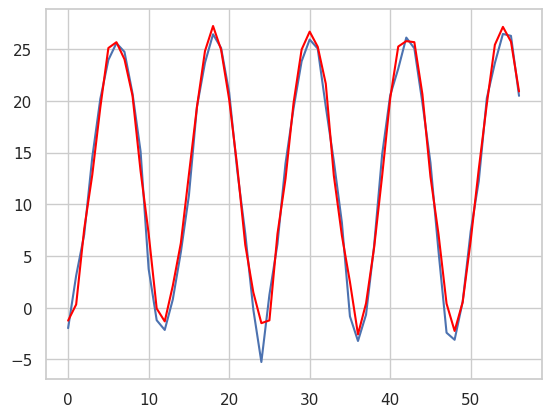

In [66]:
X = dfmundoSERIES.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

#Nos movemos de a un lag por vez y entrenamos el modelo sucesivas veces, a partir de la historia disponible
for t in range(len(test)):
	model = ARIMA(history, order=(6,0,9))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()